In [41]:
import torchvision.transforms as T
from dataset import MultiCare_XRay
from backend_central_dev.utils import plotting_utils
from torch.utils.data import DataLoader

# Define the learning rate for the optimizer
learning_rate = 1e-4

# Image size
image_size = 128

# Define the number of epochs for training
nepochs = 200

# Define the batch size for mini-batch gradient descent
batch_size = 128

tf = [T.ToPILImage(), T.Resize(size=(image_size, image_size)), T.ToTensor()]

train = MultiCare_XRay(is_train=True, transform=tf,
                       download=True, verbose=True)
# print()
test = MultiCare_XRay(is_train=False, transform=tf,
                      download=True, verbose=True)

Dataset exist:  /Users/yinnnyou/autodl-tmp/ml_data/multicare/multicare_radiology_xray
Saliency Dataset exist:  None
Train set, size: 7695
Dataset exist:  /Users/yinnnyou/autodl-tmp/ml_data/multicare/multicare_radiology_xray
Saliency Dataset exist:  None
Test set, size: 1924


torch.Size([3, 128, 128])


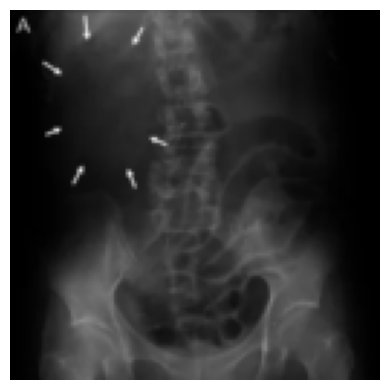

'A plain abdominal X-ray at admission showed a sparse bubbly shadow in the area of the right kidney (A).'

In [42]:
i = 1
print(train[i][0].shape)
plotting_utils.plot_hor([train[i][0].permute(1, 2, 0)])
train[i][1]

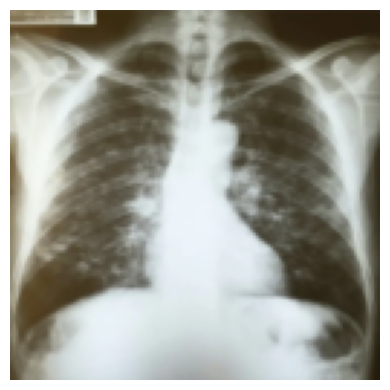

Chest x-ray showing nodules with predominantly central distribution affecting both lungs, some with signs of cavitation and bilateral perihilar reticular infiltrate.


In [43]:
dataiter = next(iter(DataLoader(train, batch_size=64)))
x, y = dataiter
i = 9
plotting_utils.plot_hor([x[i].permute(1, 2, 0)])
print(y[i])

In [44]:
import os
from transformers import AutoTokenizer
os.environ["TOKENIZERS_PARALLELISM"] = "false"

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
print(tokenizer.vocab_size)

30522


In [45]:
import torch.nn as nn
import math


class TokenDrop(nn.Module):
    """For a batch of tokens indices, randomly replace a non-specical token.

    Args:
        prob (float): probability of dropping a token
        blank_token (int): index for the blank token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, blank_token=1, eos_token=102):
        self.prob = prob
        self.eos_token = eos_token
        self.blank_token = blank_token

    def __call__(self, sample):
        # Randomly sample a bernoulli distribution with p=prob
        # to create a mask where 1 means we will replace that token
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()

        # only replace if the token is not the eos token
        can_drop = (~(sample == self.eos_token)).long()
        mask = mask * can_drop

        # Do not replace the sos tokens
        mask[:, 0] = torch.zeros_like(mask[:, 0]).long()

        replace_with = (self.blank_token * torch.ones_like(sample)).long()

        sample_out = (1 - mask) * sample + mask * replace_with

        return sample_out


def extract_patches(image_tensor, patch_size=16):
    # Get the dimensions of the image tensor
    bs, c, h, w = image_tensor.size()

    # Define the Unfold layer with appropriate parameters
    unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)

    # Apply Unfold to the image tensor
    unfolded = unfold(image_tensor)

    # Reshape the unfolded tensor to match the desired output shape
    # Output shape: BSxLxH, where L is the number of patches in each dimension
    unfolded = unfolded.transpose(1, 2).reshape(
        bs, -1, c * patch_size * patch_size)

    return unfolded

# sinusoidal positional embeds


class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


# Define a module for attention blocks
class AttentionBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, masking=True):
        super(AttentionBlock, self).__init__()
        self.masking = masking

        # Multi-head attention mechanism
        self.multihead_attn = nn.MultiheadAttention(hidden_size,
                                                    num_heads=num_heads,
                                                    batch_first=True,
                                                    dropout=0.0)

    def forward(self, x_in, kv_in, key_mask=None):
        # Apply causal masking if enabled
        if self.masking:
            bs, l, h = x_in.shape
            mask = torch.triu(torch.ones(l, l, device=x_in.device), 1).bool()
        else:
            mask = None

        # Perform multi-head attention operation
        return self.multihead_attn(x_in, kv_in, kv_in, attn_mask=mask,
                                   key_padding_mask=key_mask)[0]


# Define a module for a transformer block with self-attention
# and optional causal masking
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, decoder=False, masking=True):
        super(TransformerBlock, self).__init__()
        self.decoder = decoder

        # Layer normalization for the input
        self.norm1 = nn.LayerNorm(hidden_size)
        # Self-attention mechanism
        self.attn1 = AttentionBlock(hidden_size=hidden_size, num_heads=num_heads,
                                    masking=masking)

        # Layer normalization for the output of the first attention layer
        if self.decoder:
            self.norm2 = nn.LayerNorm(hidden_size)
            # Self-attention mechanism for the decoder with no masking
            self.attn2 = AttentionBlock(hidden_size=hidden_size,
                                        num_heads=num_heads, masking=False)

        # Layer normalization for the output before the MLP
        self.norm_mlp = nn.LayerNorm(hidden_size)
        # Multi-layer perceptron (MLP)
        self.mlp = nn.Sequential(nn.Linear(hidden_size, hidden_size * 4),
                                 nn.ELU(),
                                 nn.Linear(hidden_size * 4, hidden_size))

    def forward(self, x, input_key_mask=None, cross_key_mask=None, kv_cross=None):
        # Perform self-attention operation
        x = self.attn1(x, x, key_mask=input_key_mask) + x
        x = self.norm1(x)

        # If decoder, perform additional cross-attention layer
        if self.decoder:
            x = self.attn2(x, kv_cross, key_mask=cross_key_mask) + x
            x = self.norm2(x)

        # Apply MLP and layer normalization
        x = self.mlp(x) + x
        return self.norm_mlp(x)


# Define a decoder module for the Transformer architecture
class Decoder(nn.Module):
    def __init__(self, num_emb, hidden_size=128, num_layers=3, num_heads=4):
        super(Decoder, self).__init__()

        # Create an embedding layer for tokens
        self.embedding = nn.Embedding(num_emb, hidden_size)
        # Initialize the embedding weights
        self.embedding.weight.data = 0.001 * self.embedding.weight.data

        # Initialize sinusoidal positional embeddings
        self.pos_emb = SinusoidalPosEmb(hidden_size)

        # Create multiple transformer blocks as layers
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads,
                             decoder=True) for _ in range(num_layers)
        ])

        # Define a linear layer for output prediction
        self.fc_out = nn.Linear(hidden_size, num_emb)

    def forward(self, input_seq, encoder_output, input_padding_mask=None,
                encoder_padding_mask=None):
        # Embed the input sequence
        input_embs = self.embedding(input_seq)
        bs, l, h = input_embs.shape

        # Add positional embeddings to the input embeddings
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, h).expand(bs, l, h)
        embs = input_embs + pos_emb

        # Pass the embeddings through each transformer block
        for block in self.blocks:
            embs = block(embs,
                         input_key_mask=input_padding_mask,
                         cross_key_mask=encoder_padding_mask,
                         kv_cross=encoder_output)

        return self.fc_out(embs)


# Define an Vision Encoder module for the Transformer architecture
class VisionEncoder(nn.Module):
    def __init__(self, image_size, channels_in, patch_size=16, hidden_size=128,
                 num_layers=3, num_heads=4):
        super(VisionEncoder, self).__init__()

        self.patch_size = patch_size
        self.fc_in = nn.Linear(
            channels_in * patch_size * patch_size, hidden_size)

        seq_length = (image_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length,
                                                      hidden_size).normal_(std=0.02))

        # Create multiple transformer blocks as layers
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads,
                             decoder=False, masking=False) for _ in range(num_layers)
        ])

    def forward(self, image):
        bs = image.shape[0]

        patch_seq = extract_patches(image, patch_size=self.patch_size)
        patch_emb = self.fc_in(patch_seq)

        # Add a unique embedding to each token embedding
        embs = patch_emb + self.pos_embedding

        # Pass the embeddings through each transformer block
        for block in self.blocks:
            embs = block(embs)

        return embs


# Define an Vision Encoder-Decoder module for the Transformer architecture
class VisionEncoderDecoder(nn.Module):
    def __init__(self, image_size, channels_in, num_emb, patch_size=16,
                 hidden_size=128, num_layers=(3, 3), num_heads=4):
        super(VisionEncoderDecoder, self).__init__()

        # Create an encoder and decoder with specified parameters
        self.encoder = VisionEncoder(image_size=image_size, channels_in=channels_in,
                                     patch_size=patch_size, hidden_size=hidden_size,
                                     num_layers=num_layers[0], num_heads=num_heads)

        self.decoder = Decoder(num_emb=num_emb, hidden_size=hidden_size,
                               num_layers=num_layers[1], num_heads=num_heads)

    def forward(self, input_image, target_seq, padding_mask):
        # Generate padding masks for the target sequence
        bool_padding_mask = padding_mask == 0

        # Encode the input sequence
        encoded_seq = self.encoder(image=input_image)

        # Decode the target sequence using the encoded sequence
        decoded_seq = self.decoder(input_seq=target_seq,
                                   encoder_output=encoded_seq,
                                   input_padding_mask=bool_padding_mask)
        return decoded_seq

In [46]:
from torch import optim

# Check if GPU is available, set device accordingly
device = torch.device('mps')

# Embedding Size
hidden_size = 192

# Number of Transformer blocks for the (Encoder, Decoder)
num_layers = (6, 6)

# MultiheadAttention Heads
num_heads = 8

# Size of the patches
patch_size = 8

learning_rate = 1e-4

# Create model
caption_model = VisionEncoderDecoder(
    image_size=image_size, channels_in=3,
    num_emb=tokenizer.vocab_size, patch_size=patch_size,
    num_layers=num_layers, hidden_size=hidden_size,
    num_heads=num_heads
).to(device)

# Initialize the optimizer with above parameters
optimizer = optim.Adam(caption_model.parameters(), lr=learning_rate)

scaler = torch.cuda.amp.GradScaler()

# Define the loss function
loss_fn = nn.CrossEntropyLoss(reduction="none")

td = TokenDrop(0.5)

# Initialize the training loss logger
training_loss_logger = []

data_loader_train = DataLoader(train, batch_size=batch_size, shuffle=True)

/Users/yinnnyou/anaconda3/envs/computing-solution/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [48]:
from tqdm.notebook import trange, tqdm
# Iterate over epochs
for epoch in trange(0, nepochs, leave=False, desc="Epoch"):
    # Set the model in training mode
    caption_model.train()
    steps = 0
    # Iterate over the training data loader
    for images, captions in tqdm(data_loader_train, desc="Training", leave=False):

        images = images.to(device)

        # Tokenize and pre-process the captions
        tokens = tokenizer(captions, padding=True,
                           truncation=True, return_tensors="pt")
        token_ids = tokens['input_ids'].to(device)
        padding_mask = tokens['attention_mask'].to(device)
        bs = token_ids.shape[0]

        # Shift the input sequence to create the target sequence
        target_ids = torch.cat((token_ids[:, 1:],
                                torch.zeros(bs, 1, device=device).long()), 1)

        tokens_in = td(token_ids)
        with torch.cuda.amp.autocast():
            # Forward pass
            pred = caption_model(images, tokens_in, padding_mask=padding_mask)

        # Compute the loss
        loss = (loss_fn(pred.transpose(1, 2), target_ids) * padding_mask).mean()

        # Backpropagation
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Log the training loss
        training_loss_logger.append(loss.item())
        break
    break

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

/Users/yinnnyou/anaconda3/envs/computing-solution/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [50]:
data_loader_val = DataLoader(test, batch_size=batch_size, shuffle=True)

# Create a dataloader itterable object
dataiter = next(iter(data_loader_val))
# Sample from the itterable object
test_images, test_captions = dataiter

In [51]:
# Choose an index within the batch
index = 0
test_image = test_images[index].unsqueeze(0)

63-year-old woman with intracystic papillary carcinoma of the right breast. Right MLO view of a well circumscribed mass (arrow).


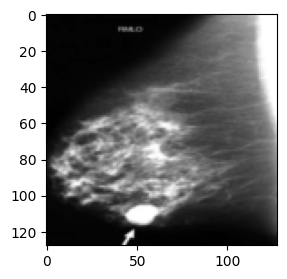

In [53]:
import torchvision
# Lets visualise an entire batch of images!
plt.figure(figsize=(3, 3))
out = torchvision.utils.make_grid(test_image, 1, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))
print(test_captions[index])

In [54]:
# Add the Start-Of-Sentence token to the prompt to signal the network to start generating the caption
sos_token = 101 * torch.ones(1, 1).long()

# Set the temperature for sampling during generation
temp = 0.5

In [68]:
sos_token

tensor([[101]])

In [69]:
from torch.distributions import Categorical

log_tokens = [sos_token]
caption_model.eval()

with torch.no_grad():
    # Encode the input image
    with torch.cuda.amp.autocast():
        # Forward pass
        image_embedding = caption_model.encoder(test_image.to(device))

    # Generate the answer tokens
    for i in tqdm(range(10), desc="Caption Generation"):
        input_tokens = torch.cat(log_tokens, 1)

        # Decode the input tokens into the next predicted tokens
        data_pred = caption_model.decoder(
            input_tokens.to(device), image_embedding)

        # Sample from the distribution of predicted probabilities
        dist = Categorical(logits=data_pred[:, -1] / temp)
        next_tokens = dist.sample().reshape(1, 1)

        # Append the next predicted token to the sequence
        log_tokens.append(next_tokens.cpu())

        # Break the loop if the End-Of-Caption token is predicted
        if next_tokens.item() == 102:
            break

Caption Generation:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Convert the list of token indices to a tensor
pred_text = torch.cat(log_tokens, 1)

# Convert the token indices to their corresponding strings using the vocabulary
pred_text_strings = tokenizer.decode(pred_text[0], skip_special_tokens=True)

# Join the token strings to form the predicted text
pred_text = "".join(pred_text_strings)

# Print the predicted text
print(pred_text)

marlene meridian leonardoraphy austria sprang princely tickets courtesy martian


: 